## <font color='blue'> ASTR 21100/31200</font>

## <font color='blue'> Homework Assignment 4</font>
    
## <font color='blue'> Approximating 2D function using interpolation and regression</font>

## <font color='blue'> Implementing Differential Evolution algorithm</font>

## <font color='blue'> undergraduate students (30 points + 7 extra-credit)</font>
    
### <font color='blue'> Distributed: Friday, April 22</font>

### <font color='blue'> Due: Friday, Apr 29, 9pm</font>

***Note that you can do exercise 4 instead of 3 or do both 3 and 4 for extra-credit.***


import packages needed by the codes below. Run this cell first before using these codes. 

In [78]:
import numpy as np

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

from codes.plotting import plot_prettier, plot_line_points

plot_prettier()

## <font color='blue'>Exercise 1 (10 points): constructing optimal approximation for $d_L(\Omega_{\rm m0},\Omega_\Lambda)$</font>

**Background.** In the past two weeks you learned how to compute of the luminosity distance $d_L(z,H_0,\Omega_{\rm m0},\Omega_\Lambda)$. You also learned that this computation is sufficiently computationally expensive that would make it prohibitively expensive if we needed to evaluate it million or so times. The need to do so arises in statistical analyses when we try to find the best combination of $M$, $\Omega_{\rm m0}$, $\Omega_\Lambda$ that describe supernovae measurements or when we need to sample the range of these parameters  MCMC sampling that we will discuss next. 

This motivates constructing accurate approximations for $d_L(z,H_0,\Omega_{\rm m0},\Omega_\Lambda)$ using methods that we've been discussing in the last couple of classes (interpolation or regression). $d_L$ is a function of 4 parameters, but we do not need to construct approximation as a function of the Hubble constant $H_0$. This is because $d_L$ is proportional to $c/H_0$ and this is the only place where $H_0$ appears in its expression. Thus, if we tabulate $\tilde{d}_L(z,\Omega_{\rm m0},\Omega_\Lambda)=d_L/(c/H_0)$, we can always then compute the actual value of the luminosity distance $d_L=c/H_0\,\tilde{d}_L(z,\Omega_{\rm m0}, \Omega_\Lambda)$. 


**Goal of the exercise.** The goal of this exercise is for you to find an optimal approximation of $\tilde{d}_L$ (i.e. $d_L$ without $c/H_0$ factor) as a function of $\Omega_{\rm m0}$ and $\Omega_\Lambda$ (that is approximation should be two-dimensional, not two separate 1d approximations as a function of $\Omega_{\rm m0}$ and $\Omega_\Lambda$) for a given single value of $z$. 

"Optimal" here means that provides target accuracy of the approximation with the smallest training set of tabulated function values. Suppose our target fractional accuracy for $\tilde{d}_L$ is $<10^{-4}$. Experiment with 2D polynomial and 2D piecewise spline interpolation for $\tilde{d}_L$ with different number of training points using codes provided below and examples from the notebook [08_multid_optimization_class](https://drive.google.com/file/d/1-ptIvIvbRqtObk8x09ausJanXcqL8pJ0/view?usp=sharing). 

In [79]:
def polyfit2d(xtr, ytr, ftr, order=None):
    '''
    Parameters:
        xtr, ytr - 1d numpy vectors with training points of x and y
        ftr - function values at xtr, ytr values
        order - int, order of the polynomial
        
    Returns:
        coefficients of the 2D polynomial
    '''
    # generate 2d coordinates on a rectangular grid
    x, y = np.meshgrid(xtr, ytr)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((order+1, order+1))
    # array that will contain polynomial term values 
    s = np.zeros((coeffs.size, x.size))

    # construct the 2D matrix of values for each polynomial term i, j
    for index, (j, i) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = x**i * y**j # coeffs[i, j] * 
        s[index] = arr.flatten() 
        
    # solve for the polynomial coefficients using least squares approximation of ftr values 
    return np.linalg.lstsq(s.T, np.ravel(ftr), rcond=None)[0]

def poly2d(xtest, ytest, a):
    '''
    Compute values of the 2D polynomial given the coefficients in 1d array a 
    at points given by 2d arrays xtest and ytest (generated using meshgrid)
    '''
    order1 = np.rint(a.size**0.5).astype(int)
    return np.polynomial.polynomial.polyval2d(xtest, ytest, a.reshape((order1,order1)))
    

Below are functions to compute $\tilde{d}_L$ using AstroPy function and custom function presented in <tt>hw02_solutions</tt> botebook. 

In [80]:
from astropy.cosmology import LambdaCDM
import astropy.units as u

def d_l_tilde_astropy(z, H0, Om0, OmL, clight=2.99792e5):
    '''
    compute d_l_tilde using AstroPy d_L function
    
    Parameters:
    
    z - float, or numpy array, redshift
    H0 - float, Hubble constant in km/s/Mpc
    Om0, OmL - floats, dimensionless matter and dark energy densities
    
    Returns:
    
        d_L - float, or numpy array, rescaled by c/H0 in Mpc 
    '''
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=OmL)
    
    return cosmo.luminosity_distance(z=z) / u.Mpc / (clight/H0)

In [81]:
def Rmm(a, b, func, m, *args):
    """
    Auxiliary function computing tableau entries for Romberg integration
    using recursive relation, but implemented non-recursively
    
    Parameters:
    -----------------
    func - python function object
            function to integrate
    a, b - floats
            integration interval            
    m    - integer
            iteration level; accuracy order will be equal to 2(m+1)
            in this implementation there is no need for k on input
            
    args - pointer to a list of arguments to be passed to the integrated function
            
    Returns:
    ---------
    
    I(m)   - float
              estimate of the integral using scheme of order 2*m+2
    I(m-1) - float
              estimate of the integral using scheme of order 2*m
    """
    assert(m >= 0)
    
    ba = b - a;
    hk = ba / 2**(np.arange(m+1)) # vector of step sizes

    Rkm = np.zeros((m+1,m+1)) 

    Rkm[0,0] = 0.5 * ba * (func(a, *args) + func(b, *args))
        
    for k in range(1,m+1):
        # first compute R[k,0]
        trapzd_sum = np.sum(func(a + (2.*np.arange(1, 2**(k-1)+1)-1)*hk[k], *args))
            
        # we can reuse Rkm[k-1,0] but we need to divide it by 2 to account for step decrease 
        Rkm[k,0] = Rkm[k-1,0] * 0.5 + hk[k] * trapzd_sum
        
        # then fill the tableau up to R[k,k]
        for md in range(1,k+1):
            fact = 4.**md
            Rkm[k,md] = (fact * Rkm[k,md-1] - Rkm[k-1,md-1])/(fact - 1)

          
    return Rkm[m,m], Rkm[m,m-1] # return the desired approximation and best one of previous order 

def romberg(func, a, b, rtol = 1.e-4, mmax = 20, verbose = False, args=[]):
    """
    Romberg integration scheme to evaluate
            int_a^b func(x)dx 
    using recursive relation to produce higher and higher order approximations
    
    Code iterates from m=0, increasing m by 1 on each iteration.
    Each iteration computes the integral using scheme of 2(m+2) order of accuracy 
    Routine checks the difference between approximations of successive orders
    to estimate error and stops when a desired relative accuracy 
    tolerance is reached.

    Parameters:
    --------------------------------
    
    func - python function object
            function to integrate
    a, b - floats
            integration interval
    rtol - float 
            fractional tolerance of the integral estimate
    mmax - integer
            maximum number of iterations to do 
    verbose - logical
            if True print intermediate info for each iteration
    kwargs - python dictionary
             a list of parameters with their keywords to pass to func
               
    Returns:
    ---------------------------------
    I    - float
           estimate of the integral for input f, [a,b] and rtol
    err  - float 
           estimated fractional error of the estimated integral

    """
    assert(a < b)
    
    for m in range(1, mmax):
        Rmk_m, Rmk_m1 = Rmm(a, b, func, m, *args)
            
        if Rmk_m == 0:
            Rmk_m = 1.e-300 # guard against division by 0 
            
        etol = 1.2e-16 + rtol*np.abs(Rmk_m)
        err = np.abs(Rmk_m-Rmk_m1)

        if verbose: 
            print("m = %d, integral = %.6e, prev. order = %.6e, frac. error estimate = %.3e"%(m, Rmk_m, Rmk_m1, err/Rmk_m))

        if (m>0) and (np.abs(err) <= etol):
            return Rmk_m, err/Rmk_m
        
    print("!!! Romberg warning: !!!")
    print("!!! maximum of mmax=%d iterations reached, abs(err)=%.3e, > required error rtol = %.3e"%(mmax, np.abs(err/Rmk_m), rtol))
    return Rmk_m, err/Rmk_m

In [82]:
def d_L_no_de(z, H0, Om0, clight = 2.99792458e5):
    '''
    function estimating d_L in Mpc, works only for models with OmL = 0
    
    Parameters:
    -----------
        z - float(s), a float or a numpy vector of floats containing redshift(s) for which to compute d_L
        H0 - Hubble constant in km/s/Mpc
        Om0 - dimensionless mean matter density in units of the critical density
        
    Returns:
    --------
        d_L - float(s), float or numpy vector of floats containing d_L in Mpc for inpute value(s) of z
                normalized to c/H0
    '''
    assert(Om0 >=0)
    q0 = 0.5 * Om0
    q0z = q0 * z
    return z * (1. + (z-q0z) / (1. + q0z + np.sqrt(1. + 2.*q0z)))  

In [83]:
def dl_func(z, Om0, OmL, Omk):
    z1 = 1.0 + z; z12 = z1 * z1
    return 1.0 / np.sqrt(z12*(Om0*z1 + Omk) + OmL)

In [84]:
def d_l_tilde(z, H0, Om0, OmL, rtol=1.e-8, mmax=20, clight=2.99792458e5):
    """
    routine computing luminosity distance from z=0 to z 
    using helper routine for comoving distance _dc
    
    Parameters:
    -----------
    z: float - redshift to which to compute d_L
    H0: float - Hubble constant in units of km/s/Mpc
    Om0: float - dimensionless mean matter density in the universe, >= 0
    OmL: float - dimensionless mean vacuum energy density in the universe
    hstep: float - step size to use
     
    Returns:
    --------
    float - value of d_L(z, H0, Om0, OmL) 
            estimated using trapezoidal integration with step size hstep 
    """
    if 1.0+OmL == 1.0: # note that I exploit the roundoff error in testing whether OmL is consistent with zero
        return d_L_no_de(z, H0, Om0) # if OmL=0, use simple formula without integration
    else: # otherwise use numerical integration to compute distance 
        #dH = clight / H0 
        dH = 1.
        Omk = 1.0 - Om0 - OmL
        args = [Om0, OmL, Omk]
        dc = romberg(dl_func, 0, z, args=args, rtol=rtol)[0]
        if 1.0 + Omk == 1.0:
            return dH * dc * (1.0 + z)
        else:
            sqrOmk = np.sqrt(np.abs(Omk))
            if Omk > 0.:
                return dH * np.sinh(dc*sqrOmk) * (1.0 + z) / sqrOmk 
            else:
                return dH * np.sin(dc*sqrOmk) * (1.0 + z) / sqrOmk
            


In [85]:
# check custom function for tilde_d_l above against astropy
print(d_l_tilde_astropy(2, 70, 0., .9), d_l_tilde(2., 70., 0., .9, rtol=1.e-16, mmax=20))

5.52787249006144 5.527864045000422


In [86]:
# We use Chebyshev type 2 nodes because they include interval edges
def chebyshev_nodes2(a, b, N):
    return a + 0.5*(b-a)*(1. + np.cos(np.arange(N+1)*np.pi/N))

In [87]:
def get_dl_grid(nt=15, z=2.0, H0=70., spacing='even', method='polynomial', 
                      om0min=0., om0max = 1., omlmin=0., omlmax=1.):
    '''
    Generate a grid of training values of d_L for a given redshift z, H0, and range
    of Om0 and OmL for specified number of training points and their spacing
    
    Parameters:
        nt - int, number of points in 1D in each parameter 
        z - float, redshift for which to compute d_L_tilde values
        H0 - float, Hubble constant in km/s/Mpc
        om0min, om0max - floats, range of Omega_m0 values for which to generate training and test values
        omlmin, omlmax - floats, range of Omega_Lambda values 
                
    Returns:
        om0tr, omltr - 1d numpy arrays of floats, training points
        om0t, omlt   - 1d numpy arrays of floats, test points 
        dl_train, dl_test - 2d arrays of training and test values of d_L_tilde
    '''
    if spacing == 'even':
        om0tr = np.linspace(om0min, om0max, nt)
        omltr = np.linspace(omlmin, omlmax, nt)
    elif spacing == 'chebyshev':
        om0tr = chebyshev_nodes2(om0min, om0max, nt-1)
        omltr = chebyshev_nodes2(om0min, om0max, nt-1)
        if method == 'spline':
            om0tr = om0tr[::-1]
            omltr = omltr[::-1]
    else: 
        raise ValueError('invalid spacing specified')
        
    dl_t = np.zeros((nt, nt)) # initialize 2D numpy array for 2D grid of d_L values     
    # Now cycle through Om0 and OmL values, compute d_L and fill the dlgrid array with values
    for i, omd in enumerate(om0tr):
        for j, omld in enumerate(omltr):
                dl_t[i,j] = d_l_tilde(z, H0, omd, omld) #d_l_tilde(z, H0, omd, omld)

    return om0tr, omltr, dl_t



**Task 1b (6 points).** Using functions <tt>polyfit2d</tt> and <tt>poly2d</tt> below construct 2D polynomial approximations of $\tilde{d}_L(z,\Omega_{\rm m0}, \Omega_\Lambda)$ for a given input single value of redshift $z$ and for ranges of the $\Omega_{\rm m0}$ and $\Omega_\Lambda)$ parameters of $\Omega_{\rm m0}\in [0,2]$ and $\Omega_\Lambda\in[0,2]$. 

Try different number of training points and polynomial order and try to find the minimal number and order that ensures the target fractional accuracy of $<10^{-4}$ for any $z$ in the interval $z\in [0,2]$. 

You should:

* Report the minimal number of training points that you find. 

* Present a calculation or a plot that demonstrates that fractional error is smaller than $10^{-4}$ for the entire range of  $z\in [0,2]$.


Based on the results of 1a and 2b, state your conclusions about the optimal method for approximating $\tilde{d}_L(z,\Omega_{\rm m0}, \Omega_\Lambda)$ with this target accuracy. 

#### Solution: 

Given that supernovae in the sample all have redshifts $z<2$. It is sufficient to ensure that distances up to $z=2$ are accurate to this redshift. Furthermore, as discussed in class, the $d_L$ function becomes more curved and more difficult to approximate with increasing $z$. Thus, for the range $z\in [0,2]$ it is sufficient to ensure that we get approximation to the required accuracy at $z=2$ and it will be definitely better at all smaller $z$. 

Thus, the tests below use $z=2$. 

In [88]:
from scipy.interpolate import RectBivariateSpline

def get_approximation(ntrain=15, z=2, om0t=None, omlt=None, spacing='even', log=False, 
                       om0min=0., om0max=1., omlmin=0., omlmax=1., 
                       method='polynomial', order=3):
    '''
    helper function to do testing
    '''
    
    if om0t is None or omlt is None:
        raise ValueError('must specify om0t and omlt grids')
    
    om0tr, omltr, dl_tr = get_dl_grid(nt=ntrain, z=z, spacing=spacing, method=method,
                                      om0min=om0min, om0max=om0max, 
                                      omlmin=omlmin, omlmax=omlmax)
    
    
    
    if method == 'polynomial':
        omgt, omlgt = np.meshgrid(om0t, omlt)
        if log: 
            a = polyfit2d(om0tr, omltr, np.log10(dl_tr), order=order)
            fpoly = 10.**poly2d(omgt, omlgt, a)
        else:
            a = polyfit2d(om0tr, omltr, dl_tr, order=order)
            fpoly = poly2d(omgt, omlgt, a)
        return omgt, omlgt, fpoly 
    
    elif method == 'spline':
        assert(order<=5)
        # [::-1] below reverses order to make values increase monotonically
        omgt, omlgt = np.meshgrid(om0t, omlt)

        if log: 
            fspl = RectBivariateSpline(om0tr, omltr, np.log10(dl_tr), s=0, kx=order, ky=order)
            return  omgt, omlgt, 10**fspl(om0t, omlt).T
        else:
            fspl = RectBivariateSpline(om0tr, omltr, dl_tr, s=0, kx=order, ky=order)
            return  omgt, omlgt, fspl(om0t, omlt).T
    
    else:
        print('method is not valid')

**1a. Spline approximation.** Experimentation shows that one can approximate $\tilde{d}_L$ with the smallest number of training points when approximating $\log_{10} \tilde{d}_L$ and using Chebyshev node spacing

In [89]:
ferr_old = 1.

omt, omlt, dl_test = get_dl_grid(nt=100, z=2.0)
order = 3
for ntrain in range(10,60):
    omgt, omlgt, dlpoly = get_approximation(ntrain=ntrain, om0t=omt, omlt=omlt, 
                                            spacing='even', log=False,  
                                            method='spline', order=order)        
    ferr = np.abs(dlpoly/dl_test.T - 1.0)
    if ferr.max() < ferr_old: 
        print(f'order = {order:d}, ntrain = {ntrain:d}, ferr_max = {ferr.max():.4e}')
        ferr_old = ferr.max()
    # break out of the inner loop if ferr is smaller than 1e-4
    if ferr.max() < 1.e-4: break

order = 3, ntrain = 10, ferr_max = 9.4743e-03
order = 3, ntrain = 11, ferr_max = 7.7755e-03
order = 3, ntrain = 12, ferr_max = 6.4267e-03
order = 3, ntrain = 13, ferr_max = 5.3247e-03
order = 3, ntrain = 14, ferr_max = 4.4192e-03
order = 3, ntrain = 15, ferr_max = 3.7893e-03
order = 3, ntrain = 16, ferr_max = 3.2769e-03
order = 3, ntrain = 17, ferr_max = 2.8403e-03
order = 3, ntrain = 18, ferr_max = 2.4667e-03
order = 3, ntrain = 19, ferr_max = 2.1458e-03
order = 3, ntrain = 20, ferr_max = 1.8693e-03
order = 3, ntrain = 21, ferr_max = 1.6302e-03
order = 3, ntrain = 22, ferr_max = 1.4230e-03
order = 3, ntrain = 23, ferr_max = 1.2429e-03
order = 3, ntrain = 24, ferr_max = 1.0861e-03
order = 3, ntrain = 25, ferr_max = 9.8516e-04
order = 3, ntrain = 26, ferr_max = 8.9699e-04
order = 3, ntrain = 27, ferr_max = 8.1790e-04
order = 3, ntrain = 28, ferr_max = 7.4681e-04
order = 3, ntrain = 29, ferr_max = 6.8277e-04
order = 3, ntrain = 30, ferr_max = 6.2497e-04
order = 3, ntrain = 31, ferr_max =

In [90]:
ferr_old = 1.
omt, omlt, dl_test = get_dl_grid(nt=100, z=2.0)

for ntrain in range(10,50):
    for order in range(3,5):
        omgt, omlgt, dlpoly = get_approximation(ntrain=ntrain, om0t=omt, omlt=omlt, 
                                                spacing='chebyshev', log=True,  
                                                method='spline', order=order)        
        ferr = np.abs(dlpoly/dl_test.T - 1.0)
        if ferr.max() < ferr_old: 
            print(f'order = {order:d}, ntrain = {ntrain:d}, ferr_max = {ferr.max():.4e}')
            ferr_old = ferr.max()
    # break out of the inner loop if ferr is smaller than 1e-4
    if ferr.max() < 1.e-4: break

order = 3, ntrain = 10, ferr_max = 1.5559e-03
order = 4, ntrain = 10, ferr_max = 1.3533e-03
order = 3, ntrain = 11, ferr_max = 9.4422e-04
order = 4, ntrain = 11, ferr_max = 8.8040e-04
order = 3, ntrain = 12, ferr_max = 5.8832e-04
order = 4, ntrain = 12, ferr_max = 5.6551e-04
order = 3, ntrain = 13, ferr_max = 3.7868e-04
order = 4, ntrain = 13, ferr_max = 3.6567e-04
order = 3, ntrain = 14, ferr_max = 2.3325e-04
order = 4, ntrain = 14, ferr_max = 2.2808e-04
order = 3, ntrain = 15, ferr_max = 1.5594e-04
order = 4, ntrain = 15, ferr_max = 1.4900e-04
order = 3, ntrain = 16, ferr_max = 8.9605e-05


We can see that we can reach target accuracy with only 16 training points and cubic spline. 

Using even spacing requires 4th order spline and 39 training points. 

Using Chebyshev nodes but approximating $\tilde{d}_L$ instead of $\log_{10}\tilde{d}_L$ can be achieved with cubic spline and 18 training points. 

Here is a plot of the fractional error for the optimal configuration. 

ferr_min = -7.2048e-05,  ferr_max = 9.4901e-05


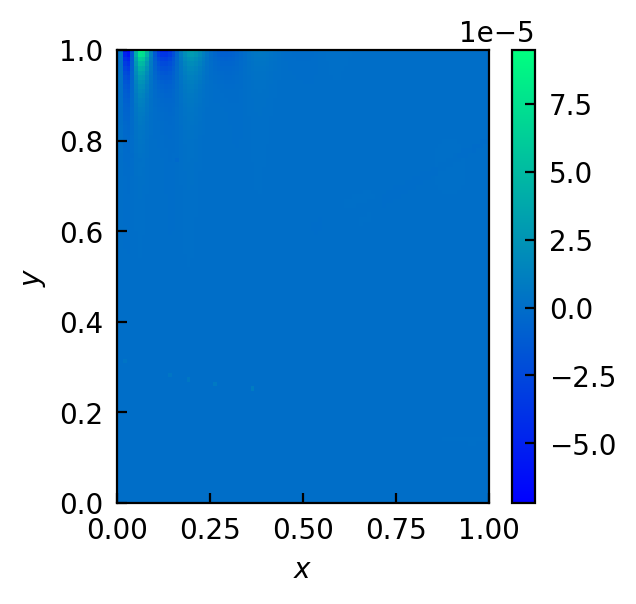

In [91]:
from codes.plotting import plot_color_map

ferr = dlpoly/dl_test.T - 1.0
#
print(f'ferr_min = {ferr.min():.4e},  ferr_max = {ferr.max():.4e}')

# plot approximating polynomial
plot_color_map(omgt, omlgt, ferr, xlim=[0.,1.], ylim=[0.,1.], 
                   xlabel = '$x$', ylabel = '$y$', cmap='winter', colorbar=True, 
                   figsize=3.0)

Chebyshev node spacing here does not have the role they play for the polynomial approximation in suppressing oscillatory behavior (not relevant for piecewise low-order polynomial splines). The reason Chebyshev nodes work better here is simply because there are more of them near the edges of the interval and so more training points near $\Omega_{\rm m0}\approx 0$ and $\Omega_\Lambda\approx 1$ where $d_L$ changes fast. 

We can achieve even better results with custom training point spacing which puts more training points in that region.  Example below shows that spacing $\Omega_{\rm m0}$ values as $\Omega_{\rm m0}^2$ and $\Omega_{\Lambda}^{1.75}$ spacing allows to get target accuracy with only 13 training points  in $\Omega_{\rm m0}$ dimension and 9 training points in $\Omega_\Lambda$ dimension.

In [92]:
om0min, om0max = 0., 1.
omLmin, omLmax = 0., 1.

# numbers of training points in each dimension 
nom0 = 13; nomL = 9
om0tr = om0min + (om0max-om0min) * np.linspace(0.,1.,nom0)**2 # square-law 
omltr = omLmin + (omLmax-omLmin) * (1.- np.linspace(0.,1.,nomL)**1.75)
# the values of OmLtr are in descending order, so reverse the order before use
omltr = omltr[::-1]


dltr = np.zeros((nom0, nomL))
H0 = 70.
z = 2.0

for i, omd in enumerate(om0tr):
    for j, omld in enumerate(omltr):
        # cancel the c/H0 factor to tabulate d_L without it
        dltr[i,j] =  d_l_tilde(z, H0, omd, omld,  rtol=1e-10)


fspl = RectBivariateSpline(om0tr, omltr, np.log10(dltr), s=0, kx=3, ky=3)

omt, omlt = np.linspace(0.,1.,100), np.linspace(0.,1.,100)

dltest = np.zeros((100,100))
for i, omd in enumerate(omt):
    for j, omld in enumerate(omlt):
        # cancel the c/H0 factor to tabulate d_L without it
        dltest[i,j] =  d_l_tilde(z, H0, omd, omld,  rtol=1e-10)

dlspl = 10.**fspl(omt,omlt)

ferr = np.abs(dlspl/dltest - 1.0)

print(f'ferr_max = {ferr.max():.4e}')

ferr_max = 5.1443e-05


**1b. Polynomial approximation.** 

Experimentation by hand shows that one gets close to the required for $n_{\rm train}>20$ and polynomial order > 10. The code below scans the range of values of $n_{\rm train}$ and order to find the combination that can reach target fractional accuracy of $10^{-4}$. This proves to be impossible for almost all choices due to roundoff errors. However, it is possible to reach this using Chebyshev placement of the training points and approximating $\log \tilde{d}_L$ instead of $\tilde{d}_L$ itself, as shown below, where target accuracy is reached for $n_{\rm train}=21$ and 15th order. 

In [93]:
ferr_old = 1.

for ntrain in range(20,36):
    for order in range(10,36):
        #print(ntrain, order)
        omgt, omlgt, dlpoly = get_approximation(ntrain=ntrain, om0t=omt, omlt=omlt, 
                                                spacing='chebyshev', log=True,  
                                                method='polynomial', order=order)        
        ferr = np.abs(dlpoly/dl_test.T - 1.0)
        # break out of the inner loop if ferr stops decreasing
        if ferr.max() < ferr_old: 
            #
            print(f'order = {order:d}, ntrain = {ntrain:d}, ferr_max = {ferr.max():.4e}')
            ferr_old = ferr.max()
    if ferr_old < 1.e-4: break

order = 10, ntrain = 20, ferr_max = 8.9060e-04
order = 11, ntrain = 20, ferr_max = 5.6457e-04
order = 12, ntrain = 20, ferr_max = 3.4982e-04
order = 13, ntrain = 20, ferr_max = 2.0842e-04
order = 14, ntrain = 20, ferr_max = 1.2373e-04
order = 14, ntrain = 21, ferr_max = 1.2266e-04
order = 15, ntrain = 21, ferr_max = 8.2178e-05


Below is plot of the fractional error showing that it does not exceed the target accuracy anywhere within the range.

ferr_min = -6.7175e-05,  ferr_max = 8.2178e-05


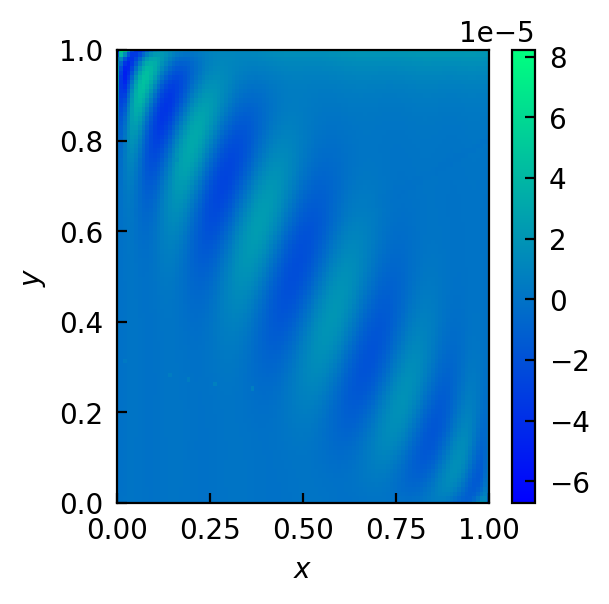

In [94]:
omgt, omlgt, dlpoly = get_approximation(ntrain=21, om0t=omt, omlt=omlt, 
                                        spacing='chebyshev', log=True,  
                                        method='polynomial', order=15)        

ferr = dlpoly/dl_test.T - 1.0
#
print(f'ferr_min = {ferr.min():.4e},  ferr_max = {ferr.max():.4e}')

# plot approximating polynomial
plot_color_map(omgt, omlgt, ferr, xlim=[0.,1.], ylim=[0.,1.], 
                   xlabel = '$x$', ylabel = '$y$', cmap='winter', colorbar=True, 
                   figsize=3.0)

To summarize, we can obtain approximations with the target accuracy both for the spline and polynomial approximation. However, for the polynomial approximation this required considerably more effort, as we had to use both Chebyshev nodes and to construct approximation for $\log_{10}\tilde{d}_L$ instead of $\tilde{d}_L$. Even then the required approximation required considerably more training points than spline approximation. 

In this case, spline approximation is superior. However, for good performance it requries spacing training points closer to the edges of the interval, as occurs in the Chebyshev spacing, where the approximated function is changing more rapidly. 

In [95]:
ferr_old = 1.

#print(ntrain, order)
omgt, omlgt, dlpoly = get_approximation(ntrain=36, om0t=omt, omlt=omlt, 
                                    spacing='even', log=False,  
                                    method='polynomial', order=36)        

ferr = np.abs(dlpoly/dl_test.T - 1.0)
print(f'ferr_min = {ferr.min():.4e},  ferr_max = {ferr.max():.4e}')


ferr_min = 4.7372e-12,  ferr_max = 1.1535e-03


## <font color='blue'>Exercise 2: implementing and testing  Differential Evolution algorithm for minimization (25 points)</font>

**Background.** Minimization in many dimensions is generally a complicated task. However, a class of <a href="https://en.wikipedia.org/wiki/Differential_evolution">Differential Evolution</a> (DE) algorithms developed from the initial ideas of R. Storn and K. Price in 1997 (<a href="https://link.springer.com/article/10.1023%2FA%3A1008202821328">Storn & Price 1997</a>), are relatively simple to implement, work in arbitrary number of dimensions, do not require function derivatives, allow imposing bounds on the domain, and are quite efficient in minimizing multi-dimensional functions.

### <font color='blue'>What you are learning in this exercise:</font>

* how to implement a general multi-dimensional minimization DE algorithm
* how to find minimum of a function in practice. 

The simplest version of the differential evolution algorithm described in detail in the notebook [08_optimization](https://drive.google.com/file/d/1oq838Jla7r6upwYf1uE7Oa6ctua0gIqU/view?usp=sharing),  can be presented as the following pseudo-code:  

    npop = np.size(x0)[0] # the number of population members
    xnow = np.copy(x0)
    fnow = np.empty(npop)
    for i in range(npop):
        fnow[i] = func(xnow[i])
    xnext = np.zeros_like(xnow)
    ....
    while some convergence criterion is not met: 
        # xnow is a vector of coordinate vectors of the current population
        # xnext is a vector of coordinate vector of the next gen population
        for i in range(npop):
            # generate random unique indices  ir1, ir2, ir3 
            # where all indices are not equal to each other and not equal to i
            # s can be a constant for large npop, but it's more safe to make it a
            # random number drawn from uniform distribution in the range [smin,1]
            xtry = xnow[ir3] + s * (xnow[ir1] - xnow[ir2])
            if func(xtry) <= fnow[i]:
                xnext[i] = xtry
                fnow[i] = func(xtry)
            else:
                xnext[i] = xnow[i]
                
        xnow = np.copy(xnext)

**Task 2a. (20 points)** Use pseudo-code of the DE algorithm above to implement DE minimization function with the following interface (15 points):

    def minimize_de(func, x0, atol=1.e-6, s=0.1, bounds=None):
        """
        Parameters:
        ------------
        func - Python function object
               function to minimize, should expect x0 as a parameter vector
        x0   - vector of real numbers of shape (npop, nd), 
                where npop is population size and nd is the number of func parameters
        atol - float
                absolute tolerance threshold for change of population member positions
        s    - float 
               s parameter for scaling steps, the step size will be dwarf from uniform distribution between s and 1
        bounds - array of tuples 
                bounds for the minimization exploration; define the region in which to search for the minimum
        """
                

***Note:*** guard against for the cases when the small number of population members is used when population does not move at a given mutation stage, so that this does not result in premature stopping of the algorithm. 

***Note:*** Try to "vectorize" as much of the algorithm as possible. This code can be fully vectorized with only one loop for the mutations of the population. 


***Note:*** Assuming that we are searching for a minimum within some rectangular domain defined by the minimum and maximum values along each coordinate axis: $\mathbf{x}_{\rm min}$ and $\mathbf{x}_{\rm max}$, we can initialize the population members as 

$$\mathbf{x}_0 = \mathbf{x}_{\rm min} + (\mathbf{x}_{\rm max}-\mathbf{x}_{\rm min}) \cdot\mathrm{rand}(0,1),$$

where $\mathrm{rand}(0,1)$ is a random number uniformly distributed from 0 to 1, generated using <tt>np.random.uniform</tt>.  


***2b (5 points).*** Test your implementation using Rosenbrock function implemented below in 2- and 5-dimensions. Try different number of population members and $s$ values and choices for how $s$ is chosen and examine how results change and for what number of population members the algorithm returns correct minimum value reliably ($[1,1]$ in 2D and $[1, 1, 1, 1, 1]$ in 5D). 

* Present a brief discussion of how large population should be in 2D and 5D to get correct minimum reliably. 

* Present a brief discussion of how choices of $s$ affect results 

* Demonstrate that your function returns values within the specified atol value reliably in 5D. 

In [96]:
def rosenbrock(x):
    """The Rosenbrock "banana" function
    x is a vector of points in 2 or more dimensional space
    """
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)


In [97]:

def minimize_de(func, x0, atol=1.e-6, cr=0.7, tol=0.01, s=0.1, crossover=True, 
                               bounds=None, args=[], verbose=False):
    '''
    Differential Evolution implementation that is not fully vectorized
    '''
    assert(atol > 0.)
    npop, nd = np.shape(x0)
    xnow = np.copy(x0)
    xnext = np.zeros_like(xnow)
    dxmax = 100.*atol

    # initialize array of sequences that do not include i
    iseq_mi = np.zeros((npop, npop-1)).astype(int)
    for i in range(npop): 
        iseq_mi[i] = np.hstack((np.arange(i),np.arange(i+1,npop)))
    
    fnow = np.zeros(npop)
    for i in range(npop):
        fnow[i] = func(xnow[i], *args)
    
    fnext = np.zeros_like(fnow)
    converged = False
    jdim = np.zeros((npop,nd))
    for i in range(npop):
        jdim[i,:] = np.arange(nd)
        
    sqrts = np.sqrt(s)
    niter = 0 
    while not converged:
        niter += 1
        fnext, xnext = np.copy(fnow), np.copy(xnow)
        sr = np.random.uniform(s, 1., size=npop)
        if crossover: 
            rj = np.random.uniform(size=npop*nd).reshape(npop,nd)
            icr= rj > cr
            # this part of the cross over does not seem to have much effect and just slows down the code
            #iri = np.random.randint(0, nd, size=npop*nd).reshape(npop,nd)
            #icr2 = ~(jdim - iri).astype('bool')
            #icr = np.logical_or(icr1,icr2)
               
        for i in range(npop):
            ir = np.random.permutation(iseq_mi[i])
            xtry = xnow[ir[0]] + sr[i] * (xnow[ir[1]] - xnow[ir[2]])
            if crossover: xtry[icr[i,:]] = xnow[i,icr[i,:]]
            ftry = func(xtry, *args)
            # check boundary condition 
            bleft  = (xtry-bounds[:,0]).all() > 0
            bright = (bounds[:,1] - xtry).all() > 0
            if ftry <= fnow[i] and bleft and bright:
                xnext[i] = xtry
                fnext[i] = ftry
            else:
                xnext[i] = xnow[i]
                fnext[i] = fnow[i]
                
        converged = (np.abs(xnext - xnow).max() < atol).all()
        xnow = np.copy(xnext)
        fnow = np.copy(fnext)
        
        if verbose:
            print(np.mean(xnext, axis=0), dxmax)

    x_min = np.median(xnext, axis=0)
    print('DE finished with {:d} function evaluations'.format(niter*2))
    return x_min

The Rosenbrock function below is modified to handle vector input of the shape (ndim, npop)

In [98]:
def rosenbrock_v(x):
    """The Rosenbrock "banana" function
    x is a vector of points in 2 or more dimensional space
    """
    return np.sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0, axis=0).T


In [99]:
def minimize_de_v(func, x0, atol=1.e-6, cr=0.7, tol=0.01, s=0.1, args=[], 
                               crossover=True, bounds=None, verbose=False):
    """
    fully vectorized version of the Differential Evolution method 
    
    """
    assert(atol > 0.)
    npop, nd = np.shape(x0)
    xnow = np.copy(x0.T)
    xnext = np.zeros_like(xnow)
    dxmax = 100.*atol

    # initialize array of sequences that do not include i
    ir = np.zeros((npop, npop-1)).astype(int)
    for i in range(npop):
        ir[i,:] = np.random.permutation(np.hstack((np.arange(i),np.arange(i+1,npop))))
   
    fnow = func(xnow, *args)    
    fnext = np.zeros_like(fnow)

    jdim = np.zeros((nd,npop))
    for i in range(npop):
        jdim[:,i] = np.arange(nd)
        
    sqrts = np.sqrt(s)
    initind = np.arange(npop)

    converged = False
    
    left_bounds = np.tile(bounds.T[0], (npop,1)).T
    right_bounds = np.tile(bounds.T[1], (npop,1)).T
    
    niter = 0 
    while not converged or dxmax == 0:
        niter += 1
        xnext = np.copy(xnow)
        sr = np.random.uniform(s, np.minimum(1.+s,2.), size=npop)
        
        # the following 3 lines implement the 2nd part of crossover, 
        # but I found that this part doesn't make much difference but slows down calculation  
        #iri = np.random.randint(0, nd, size=npop*nd).reshape(nd,npop)
        #icr2 = ~(jdim - iri).astype('bool')
        #icr = np.logical_or(icr1,icr2)
        # shuffle indices 
        np.random.shuffle(ir.T)
        # trial step
        xtry = xnow[:,ir[:,0]] + np.multiply(np.tile(sr,(nd,1)), (xnow[:,ir[:,1]] - xnow[:,ir[:,2]]))
        # crossover
        if crossover: 
            rj = np.random.uniform(size=npop*nd).reshape(nd,npop)
            icr = rj > cr
            xtry[icr] = xnow[icr] 
            
        ftry = func(xtry, *args)
        iaccf = (ftry <= fnow)
        iaccx = np.tile(iaccf, (nd,1)) & (xtry >= left_bounds) & (xtry <= right_bounds)
        xnext[iaccx] = xtry[iaccx]
        fnow = func(xnext, *args)
        dxmax = np.abs(xnext - xnow).max()
        converged = (dxmax < atol).all()
        # this is an alternative convergence indicator similar to what's used in scipy.optimize.differential_evolution
        #converged = (np.std(fnow, ddof=1) <= atol + tol * np.abs(np.mean(fnow))).all()
        xnow = np.copy(xnext)
        
        if verbose:
            print(xnext[0], dxmax)
            
    x_min = np.median(xnow, axis=1)
    print('DE finished with {:d} function evaluations'.format(niter*2))
    return x_min

First test in 2D. 

In [100]:
xmin, xmax, ymin, ymax = -10, 10, -10, 10.

npop = 15
#np.random.seed(9999)

bounds = np.array([(xmin, xmax), (ymin, ymax)])
ndim = np.shape(bounds)[0]
xnow = xmin + (xmax-xmin)*np.random.uniform(size=npop*ndim).reshape(npop,ndim)

s=0.5
x_min = minimize_de_v(rosenbrock_v, xnow, s=s, bounds=bounds, atol=1e-10, args=[])

print("minimum at :", x_min)

DE finished with 766 function evaluations
minimum at : [1. 1.]


Reruning above with different <tt>npop</tt> values we can see that results are *not* stable for <tt>npop=10</tt>, while increasing <tt>npop</tt> to 15 makes it stable. Stability of the algorithm depends on the parameters which illustrates importance of such tests.  

Below is test in 5D. Here runs with <tt>npop=15</tt> do not produce correct minimum. This is because the algorithm relies on information from other population members and small number of members does not allow to explore the multi-D space faithfull. However, for <tt>npop>=20</tt> results are stable, although for numbers close to the lower limit run-times vary significantly. Run time stabilizes for <tt>npop>=30</tt>

In [101]:
from time import time

npop = 30
xmin, xmax, ymin, ymax = -10, 10, -10, 10.

bounds = np.array([(xmin, xmax), (ymin, ymax), (xmin, xmax), (ymin, ymax), (xmin, xmax)])
ndim = np.shape(bounds)[0]
xnow = xmin + (xmax-xmin)*np.random.uniform(size=npop*ndim).reshape(npop,ndim)

tstart = time()
s = 0.1
x_min = minimize_de_v(rosenbrock_v, xnow, s=s, bounds=bounds, atol=1e-10, crossover=True, args=[])
print("completed in %.3g sec"%(time() - tstart))
print("minimum at :",x_min)


DE finished with 2156 function evaluations
completed in 0.139 sec
minimum at : [1. 1. 1. 1. 1.]


Stability of the method at these <tt>npop</tt> is in large part due to the crossover stage. As can be seen below without crossover, results are not stable for <tt>npop=30</tt>, but become stable for  <tt>npop>=30</tt> and achieving even faster convergence than with <tt>npop=30</tt> and crossover. This is because crossover involves extra-work and employing it is a tradeoff.

In this particular test, function computation is not expensive, but for more expensive functions ability to converge for smaller number of walkers could result in substantial speed up. 

In [102]:
npop = 30
xmin, xmax, ymin, ymax = -10, 10, -10, 10.

bounds = np.array([(xmin, xmax), (ymin, ymax), (xmin, xmax), (ymin, ymax), (xmin, xmax)])
ndim = np.shape(bounds)[0]
xnow = xmin + (xmax-xmin)*np.random.uniform(size=npop*ndim).reshape(npop,ndim)

tstart = time()
s = 0.1
x_min = minimize_de_v(rosenbrock_v, xnow, s=s, bounds=bounds, atol=1e-8, crossover=False, args=[])
print("completed in %.3g sec"%(time() - tstart))
print("minimum at :",x_min)


DE finished with 1896 function evaluations
completed in 0.137 sec
minimum at : [1.00002517 1.00003046 1.00004779 1.00012336 1.00023675]


### Test of the effect of the cross-over stage on the speed of convergence

Below is the test that shows how implementation of the crossover stage can improve the speed of convergence. 

In [103]:
npop = 30
bounds = np.array([(xmin, xmax), (ymin, ymax), (xmin, xmax), (ymin, ymax), (xmin, xmax)])
ndim = np.shape(bounds)[0]
xnow = xmin + (xmax-xmin)*np.random.uniform(size=npop*ndim).reshape(npop,ndim)

for s in [0.05, 0.1, 0.2, 0.5, 1.]:
    tstart = time()
    s = 0.1
    x_min = minimize_de_v(rosenbrock_v, xnow, s=s, bounds=bounds, atol=1e-10, crossover=True, args=[])
    print("completed in %.3g sec"%(time() - tstart))
    print("minimum at :",x_min)


DE finished with 1774 function evaluations
completed in 0.112 sec
minimum at : [1. 1. 1. 1. 1.]
DE finished with 2074 function evaluations
completed in 0.137 sec
minimum at : [1. 1. 1. 1. 1.]
DE finished with 1930 function evaluations
completed in 0.12 sec
minimum at : [1. 1. 1. 1. 1.]
DE finished with 2552 function evaluations
completed in 0.173 sec
minimum at : [1. 1. 1. 1. 1.]
DE finished with 2188 function evaluations
completed in 0.137 sec
minimum at : [1. 1. 1. 1. 1.]


We see that the method that uses uniform distribution in $[s,1]$ interval, the speed is not strongly sensitive on the adopted $s$ value. 

#### Comparison to scipy.optimize.differential_evolution

Below the optimization for the same function and the same parameters is done for <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html"><tt>scipy.optimize.differential_evolution</tt></a>

Note that this function's parameter <tt>popsize</tt> is used to determine number of walkers (population size) as 
<tt>popsize * ndim</tt>. So <tt>popsize=6</tt> is equivalent to <tt>npop=30</tt> above for 5D Rosenbrock. 


In this function $s=$<tt>mutation</tt>, <tt>cr=recombination</tt>
<tt>crossover=1</tt> is equivalent to not doing crossover at all. <tt>mutation=[s,1.]</tt> will use random s values uniformly drawn from $[s,1]$ interval. 

Parameter <tt>strategy='rand1bin'</tt> sets the algorithm to use the variant of the DE implemented above. However, results are qualitatively the same for some other strategies I tried. 

Other input parameters are set to match the parameters used in tests above. See the above link for description of these parameters. 

In [104]:
from scipy.optimize import differential_evolution
npop = 30
bounds = np.array([(xmin, xmax), (ymin, ymax), (xmin, xmax), (ymin, ymax), (xmin, xmax)])

for s in [0.05, 0.1, 0.2, 0.5, 1.]:
    tstart = time()
    res = differential_evolution(rosenbrock, bounds=bounds, mutation=[s, 1.], recombination=0.7, 
                                   atol=1.e-10, tol=0.01, strategy='rand1bin',
                                   popsize=npop//5, polish=False)
    print("completed in %.3g sec"%(time() - tstart))
    print("found minimum at:", res.x)
    print("in {:d} function evaluations".format(res.nfev))
    print(40*'-')

completed in 1 sec
found minimum at: [1.00000032 1.00000045 1.00000084 1.00000148 1.00000311]
in 15570 function evaluations
----------------------------------------
completed in 1.17 sec
found minimum at: [1.00000042 1.00000081 1.00000116 1.00000229 1.00000485]
in 18630 function evaluations
----------------------------------------
completed in 1.11 sec
found minimum at: [0.9999994  0.99999929 0.9999985  0.99999722 0.99999445]
in 18060 function evaluations
----------------------------------------
completed in 1.25 sec
found minimum at: [0.99999994 1.00000018 1.0000006  1.00000113 1.00000197]
in 20550 function evaluations
----------------------------------------
completed in 1.79 sec
found minimum at: [0.99999626 0.99999643 0.99998913 0.99996414 0.9999455 ]
in 30030 function evaluations
----------------------------------------


Here we see that for <tt>npop=30</tt> are unstable for $s<0.2$. Thus, the number of population members needs to be increased to <tt>npop=50</tt> for stable results. 

<tt>scipy.optimize.differential_evolution</tt> reqires more walkers for stability and performs a factor of 10 slower than the version implemented above. This is because the function computation in this function is not vectorized and this carries significant overhead. 

This again shows that it is often advantageous to implement your own version of a function that you need to use often and where stability, speed, and full control over customization of the function are important and not rely on the package function. 

In [105]:
from scipy.optimize import differential_evolution
from time import time

xmin, xmax, ymin, ymax = -10., 10., -10., 10.
bounds = [(xmin, xmax), (ymin, ymax), (xmin, xmax), (ymin, ymax), (xmin, xmax)]

tstart = time()
res = differential_evolution(rosenbrock, bounds, strategy='rand1bin', mutation=0.5, recombination=1.0,
                             popsize=50, polish=False)

print("completed in %.3g sec"%(time() - tstart))
print("minimum at :",res.x)

completed in 6.04 sec
minimum at : [1. 1. 1. 1. 1.]
